# Download and Install CLIP Dependencies

In [ ]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import numpy as np
import shutil
import torch
import os
import cv2
import glob
import torch
import glob

print("Torch version:", torch.__version__)
os.kill(os.getpid(), 9)  


CUDA version: 11.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


ModuleNotFoundError: ignored

# Downloading the clip model and our Data
Here we will be downloading the clip model that we will use on the dataset we created on Roboflow.

In [ ]:
#clone the CLIP repository
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP
import clip
# download clip model
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="clip", notebook="roboflow-clip")

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 30.12 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/CLIP/CLIP
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=clip&ref=roboflow-clip


In [ ]:
# download classification data
rf = Roboflow(api_key="jyWhsscgsT3D1GKlldiT")
project = rf.workspace("project-vkjtv").project("pictures-classification")
dataset = project.version(2).download("clip")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pictures-classification-2 in clip:: 100%|██████████| 1119/1119 [00:00<00:00, 1384.71it/s]


In [ ]:
dataset.location

'/content/CLIP/CLIP/Pictures-classification-2'

In [ ]:
# our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir(dataset.location + '/test/')
class_names.remove('_tokenization.txt')
class_names
# Here we have two classes

['Professional picture', 'None Professional picture']

In [ ]:
# editing our prompts to try to get the best acuuracy, be sure the classes are in the same order as above
%%writefile {dataset.location}/test/_tokenization.txt
A smiling face indoor professional picture
Not a smiling face outdoor none professional picture and not a person picture

Overwriting /content/CLIP/CLIP/Pictures-classification-2/test/_tokenization.txt


In [ ]:
candidate_captions = []
with open(dataset.location + '/test/_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()

In [ ]:
candidate_captions

['A smiling face indoor professional picture',
 'Not a smiling face outdoor none professional picture and not a person picture']

## Runing CLIP inference on our classification dataset

In [ ]:


DATADIR = "/content/CLIP/Pictures-classification-2/test/"
CATEGORIES = ["None Professional picture", "Professional picture"]

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
prediction = []
reality = []

TP = []
TN = []
FP = []
FN = []
Total =[]

#define our target classificaitons, you can should experiment with these strings of text as you see fit, though, make sure they are in the same order as your class names above
text = clip.tokenize(candidate_captions).to(device)

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)

for cls in class_names:
    class_correct = []
    test_imgs = glob.glob(dataset.location + '/test/' + cls + '/*.jpg')
    text_features = model.encode_text(text)
    for img in test_imgs:
        # print(img)
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  

        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            print(probs)

            pred = class_names[argmax(list(probs)[0])]
            prediction.append(pred)
            print('prediction is :' + pred)
            reality.append(cls)
            print('reality is :' + cls)

            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)

            if cls == "Professional picture" and pred == cls :
              TP.append(1)
              Total.append(1)
            elif cls == "None Professional picture" and pred == cls :
              TN.append(1)
              Total.append(1)
            elif cls == "Professional picture" and pred != cls :
              FP.append(1)
              Total.append(1)
            elif cls == "None Professional picture" and pred != cls :
              FN.append(1)
              Total.append(1)
    
    print('accuracy on class ' + cls + ' is :' + str(sum(class_correct)/len(class_correct)))
    if cls == "Professional picture":
      Professional_accuracy = str(sum(class_correct)/len(class_correct))
print('accuracy on class Professional picture is :' + Professional_accuracy)

print("#####" * 50)
print("Accuracy on all is : " + str((sum(TP) + sum(TN))/sum(Total)))
print("Recall on all is : " + str(sum(TP)/(sum(TP) + sum(FN))))
print("Precision on all is : " + str(sum(TP)/(sum(TP) + sum(FP))))
print("F1 Score is : " + str((2 * sum(TP))/(2 * sum(TP) + sum(FP) + sum(FN))))
print("Specificity on all is : " + str(sum(TN)/(sum(TN) + sum(FP))))
print("FPR on all is : " + str(sum(FP)/(sum(FP) + sum(TN))))
print("FNR on all is : " + str(sum(FN)/(sum(FN) + sum(TP))))

[[0.752 0.248]]
prediction is :Professional picture
reality is :Professional picture
[[0.3074 0.693 ]]
prediction is :None Professional picture
reality is :Professional picture
[[0.8706 0.1294]]
prediction is :Professional picture
reality is :Professional picture
[[0.8335 0.1666]]
prediction is :Professional picture
reality is :Professional picture
[[0.9824  0.01744]]
prediction is :Professional picture
reality is :Professional picture
[[0.1481 0.852 ]]
prediction is :None Professional picture
reality is :Professional picture
[[0.596  0.4036]]
prediction is :Professional picture
reality is :Professional picture
[[0.8975 0.1023]]
prediction is :Professional picture
reality is :Professional picture
[[0.558  0.4417]]
prediction is :Professional picture
reality is :Professional picture
[[0.686 0.314]]
prediction is :Professional picture
reality is :Professional picture
[[0.7773 0.2227]]
prediction is :Professional picture
reality is :Professional picture
[[0.01428 0.986  ]]
prediction is :

In [ ]:
file_name_1 = glob.glob(dataset.location + '/test/' + 'None Professional picture' + '/*.jpg')
file_name_2 = glob.glob(dataset.location + '/test/' + 'Professional picture' + '/*.jpg')
file_name = file_name_1 + file_name_2

In [ ]:
file_name_1

['/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/AdNonad132_png.rf.27f24200836978cc441a5cde7f9feb43.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/AdNonad65_png.rf.8152c375f390be14d361bacdcafb7518.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/Enzo-USTARIZ_png.rf.d338c111eae774d1a7eff01ac69da118.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/Yasmina-AIT-ALI_png.rf.5ea875641e547d58d24a9ec8776918af.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/AdNonAd218_png.rf.f2902e135347a78410c5e4d6ef77c57d.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/AdNonAd171_png.rf.fd8413dbf4e0673f3bd2d1c7e469c668.jpg',
 '/content/CLIP/CLIP/Pictures-classification-2/test/None Professional picture/Xavier-Dubrulle_png.rf.a52c4ace37f53a6576417ab9c65dd19e.jpg',
 '/content/CLIP/CLIP/Pictures-classification

In [ ]:
df = pd.DataFrame(data=file_name)
df.columns=["file_name"]

In [ ]:
df["None Professional"]=df["file_name"].apply(lambda x: 1 if x in file_name_1 else 0)
df["Professional"]=df["file_name"].apply(lambda x: 1 if x in file_name_2 else 0)

In [ ]:
df

,file_name,None Professional,Professional
0,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
1,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
2,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
3,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
4,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
...,...,...,...
63,/content/CLIP/CLIP/Pictures-classification-2/t...,0,1
64,/content/CLIP/CLIP/Pictures-classification-2/t...,0,1
65,/content/CLIP/CLIP/Pictures-classification-2/t...,0,1
66,/content/CLIP/CLIP/Pictures-classification-2/t...,0,1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


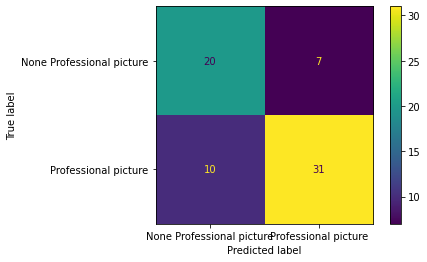

In [ ]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(reality, prediction)

In [ ]:
DATADIR = "/content/drive/MyDrive/Images/Images"
DATADIR

'/content/drive/MyDrive/Images/Images'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgs = glob.glob(DATADIR + '/*.png')

In [ ]:
from tqdm import tqdm
texte = clip.tokenize(candidate_captions).to(device)
predictions = []


imgs = glob.glob(DATADIR + '/*.png')
texte_features = model.encode_text(texte)
for img in tqdm(imgs):
    image_array = cv2.imread(os.path.join(DATADIR, img))
    # image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    # plt.imshow(image_array)
    # plt.show()

    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
          image_features = model.encode_image(image)

              
          logits_per_image, logits_per_texte = model(image, texte)
          probs = logits_per_image.softmax(dim=-1).cpu().numpy()
          # print(probs)

          pred = class_names[argmax(list(probs)[0])]
          predictions.append(pred)
          # print('prediction is :' + pred)

print(predictions)
        


100%|██████████| 3163/3163 [02:56<00:00, 17.90it/s]

['None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional pi

In [ ]:
print(probs)
print(pred)
print(imgs)

[[0.08386 0.916  ]]
None Professional picture
['/content/drive/MyDrive/Images/Images/C5603AQFiEcR5O_7auA.png', '/content/drive/MyDrive/Images/Images/C5603AQGKYtfD0ac-8Q.png', '/content/drive/MyDrive/Images/Images/C5603AQESrYUnVcYr6w.png', '/content/drive/MyDrive/Images/Images/C5603AQEbBpA8Yn3a8Q.png', '/content/drive/MyDrive/Images/Images/C5603AQFA6jvzHRA3Lg.png', '/content/drive/MyDrive/Images/Images/C5603AQEnlfqR5674eQ.png', '/content/drive/MyDrive/Images/Images/C5603AQFU0AwkJOpF1g.png', '/content/drive/MyDrive/Images/Images/C5103AQETPPmZc7o7mQ.png', '/content/drive/MyDrive/Images/Images/C5603AQFsaX2qJo59OQ.png', '/content/drive/MyDrive/Images/Images/C5603AQGHW5QYNbVaxw.png', '/content/drive/MyDrive/Images/Images/C5603AQEQOlCJfo2s2A.png', '/content/drive/MyDrive/Images/Images/C5603AQFfH7aWa2GW7A.png', '/content/drive/MyDrive/Images/Images/C5603AQERMVqjcP-swg.png', '/content/drive/MyDrive/Images/Images/C5603AQFznHUyuCtZ3w.png', '/content/drive/MyDrive/Images/Images/C5603AQEScSURly1AJQ

In [ ]:
imgs = glob.glob(DATADIR + '/*.png')

In [ ]:
len(imgs)

3163

In [ ]:
dic = dict(zip(imgs,predictions))

In [ ]:
list(dic.items())[-1]

('/content/drive/MyDrive/Images/Images/C4D03AQEx9eIyxnHE7A.png',
 'None Professional picture')

In [ ]:
df2 = pd.DataFrame(list(dic.items()),columns = ['file_name','prediction'])

In [ ]:
df2["None Professional"]=df2["prediction"].apply(lambda x: 1 if x=="None Professional picture" else 0)

In [ ]:
df2["Professional"]=df2["prediction"].apply(lambda x: 1 if x=="Professional picture" else 0)

In [ ]:
df2.drop('prediction', axis=1, inplace=True)

In [ ]:
df2["None Professional"].value_counts()

1    1890
0    1273
Name: None Professional, dtype: int64

In [ ]:
df_f=pd.concat([df,df2],ignore_index=True)

In [ ]:
df_f

,file_name,None Professional,Professional
0,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
1,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
2,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
3,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
4,/content/CLIP/CLIP/Pictures-classification-2/t...,1,0
...,...,...,...
3226,/content/drive/MyDrive/Images/Images/C4D03AQES...,0,1
3227,/content/drive/MyDrive/Images/Images/C4D03AQEg...,1,0
3228,/content/drive/MyDrive/Images/Images/C4D03AQF-...,1,0
3229,/content/drive/MyDrive/Images/Images/C4D03AQEw...,0,1


In [ ]:
path_non_pro = df_f[df_f['None Professional']==1].file_name.tolist()

In [ ]:
path_pro = df_f[df_f['Professional']==1].file_name.tolist()

In [ ]:
path_non_pro

In [ ]:
src_dir = glob.glob(DATADIR + '/*.png')
dst_dir = "/content/drive/MyDrive/Images/AD"
dst_dir_2 = "/content/drive/MyDrive/Images/NAD"

for jpgfile in src_dir:
    print(jpgfile)
    for pro in path_pro:
        print(pro)
        if pro ==jpgfile:
            shutil.move(jpgfile, dst_dir)
    for nopro in path_non_pro:
        print(nopro)
        if nopro ==jpgfile:
            shutil.move(jpgfile, dst_dir_2)

TypeError: ignored